In [20]:
from models.cnp import CNP
from data.data_generators import *
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

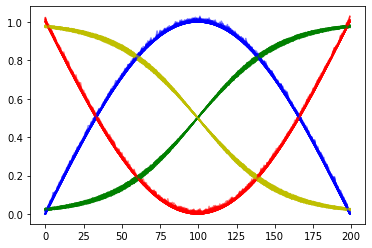

In [21]:
import matplotlib.pyplot as plt

x = torch.linspace(0, 1, 200)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, 
    generate_reverse_cx_sigm]
y = []
for i in range(32):
    for j in range(4):
        y.append(generator_functions[j](x))

colors = ["b", "r", "g", "y"]
num_classes = 4
for i, y_i in enumerate(y):
    plt.plot(y_i, alpha=0.5, c=colors[i%num_classes])



x = x.unsqueeze(0).repeat(len(y), 1).to(device)
y = torch.stack(y, dim=0).to(device)

In [22]:
model = CNP().to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [23]:
def get_batch(x, y, traj_ids):
    n = x.shape[1]
    n_t = torch.randint(1, model.n_max_tar, (1,)).item()
    n_o = torch.randint(1, model.n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, model.input_dim+model.output_dim).to(device)
    tar = torch.zeros(batch_size, n_t, model.input_dim).to(device)
    tar_val = torch.zeros(batch_size, n_t, model.output_dim).to(device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(n)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        # print(x.shape, traj_ids[i], o_ids, t_ids)

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids].unsqueeze(-1), y[traj_ids[i], o_ids].unsqueeze(-1)), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids].unsqueeze(-1)
        tar_val[i, :, :] = y[traj_ids[i], t_ids].unsqueeze(-1)

    return obs, tar, tar_val


batch_size = 32
epochs = 500000
epoch_iter = 4

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0]).chunk(epoch_iter)

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, encoded_rep = model(obs, tar_x)
        loss = model.loss(pred, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print("Epoch: {}, Loss: {}".format(epoch, epoch_loss))

Epoch: 0, Loss: 3.3722199201583862
Epoch: 1, Loss: 3.290591597557068
Epoch: 2, Loss: 3.226220965385437
Epoch: 3, Loss: 2.8679959177970886
Epoch: 4, Loss: 2.765924572944641
Epoch: 5, Loss: 2.4585534930229187
Epoch: 6, Loss: 2.202252447605133
Epoch: 7, Loss: 1.9833554327487946
Epoch: 8, Loss: 1.8555128276348114
Epoch: 9, Loss: 1.7358760237693787
Epoch: 10, Loss: 1.5338888764381409
Epoch: 11, Loss: 1.356038510799408
Epoch: 12, Loss: 1.494636446237564
Epoch: 13, Loss: 1.4097758829593658
Epoch: 14, Loss: 1.4390413761138916
Epoch: 15, Loss: 1.480523556470871
Epoch: 16, Loss: 1.5387302041053772
Epoch: 17, Loss: 1.4957682490348816
Epoch: 18, Loss: 1.455705463886261
Epoch: 19, Loss: 1.5495148301124573
Epoch: 20, Loss: 1.3734652996063232
Epoch: 21, Loss: 1.44129478931427
Epoch: 22, Loss: 1.5016840994358063
Epoch: 23, Loss: 1.4940398633480072
Epoch: 24, Loss: 1.3287602663040161
Epoch: 25, Loss: 1.3535370826721191
Epoch: 26, Loss: 1.228651911020279
Epoch: 27, Loss: 1.4240979850292206
Epoch: 28, Lo

In [ ]:
torch.save(model.state_dict(), f'cnp_on_latent_model.pt')

In [ ]:
batch_size = 128
o, t, tr = get_batch(x, y, torch.arange(batch_size))

with torch.no_grad():
    _, r = model(o, t)

print(r.shape)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

latent_values = r.squeeze(1).cpu().numpy()
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(latent_values)

print(np.mean(labels), labels, sep='\n')
pca = PCA(n_components=2)
reduced_latent = pca.fit_transform(latent_values)

label_colors = []
for i in labels:
    label_colors.append(colors[i])
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=label_colors, s=50)
